In [3]:
from brian2 import *
%matplotlib inline
import os,random

In [57]:
# Changing the time step of Brian Simulator for better resolution
sim_time = 400 * ms
time_step = 0.001 * ms
defaultclock.dt = time_step
num_neurons = 34 * 34
n_of_m =100
file_loc = "D://Download/N-MNIST/Train/"
time_dur = []
spike_digits = []
tot_spike_index = []
tot_spike_time = []
iterations = 20
accu_time = 0
interval_time = 20000


# This chooses NMNIST sample file from the folders at random
for z in range(iterations):
    digit = random.choice(os.listdir(file_loc))
    Bytes = numpy.fromfile(file_loc+'/'+digit+'/'+random.choice(os.listdir(file_loc+'/'+digit)), dtype = "uint8")
    spike_digits.append(int(digit))
    Bits = numpy.unpackbits(Bytes)
    Bits = Bits.reshape(int(len(Bits)/40), 40)

    counter_n = 0
    spike_time = []
    spike_index = []
    uniq = np.zeros(num_neurons)

    for q in Bits:
            if(counter_n>=n_of_m):
                break
            q  = np.flip(q)
            tmp = q[:23]
            time_stamp = tmp.dot(1 << np.arange(tmp.shape[-1])) 
            tmp =  q[24:32]
            y = tmp.dot(1 << np.arange(tmp.shape[-1]))
            tmp = q[32:]
            x = tmp.dot(1 << np.arange(tmp.shape[-1]))
            ind = (y*34) + x
            if(uniq[ind]==0):
                counter_n += 1
                uniq[ind] = 1
                spike_time.append((int)(accu_time+time_stamp))
                spike_index.append(ind)
    j= []
    accu_time += time_stamp + interval_time
    for a in spike_time:
        j.append(a+time_stamp + interval_time)   
    time_dur.append(time_stamp)
    accu_time += time_stamp + interval_time
    tot_spike_time = tot_spike_time + spike_time + j
    tot_spike_index = tot_spike_index + spike_index + spike_index
    
tot_spike_time *= time_step

In [58]:
vt = -54*mV
vr = -60*mV
El = -74*mV

tau_pre = 16*ms

gmax = 14
# gmax is ceiling for the weights

tau_ojas = 40
alpha = 0.5

# rates (Hz) is a neuronal variable that determines the frequency at which it spikes regardless of stimuli (0 by default)
eqs_stdp = '''
dv/dt = ( El - v) / tau_pre : volt (unless refractory)
rates : Hz
'''

SG = SpikeGeneratorGroup(num_neurons, tot_spike_index, tot_spike_time)
add = NeuronGroup(10000, eqs_stdp,reset='v=vr',threshold='v>vt', refractory= 1 * ms ,method='euler')
G2 = NeuronGroup(10, eqs_stdp,reset='v=vr',threshold='rand()<rates*dt or v>vt', refractory= 1 * ms, method='euler')

add.v = vr
G2.v = vr

Sy = Synapses(SG, add,
             'w:volt',
             on_pre='v_post += w',
             )

Sy.connect(p=0.002)
Sy.w = gmax * mV

Sy2 = Synapses(add, G2,
             '''w : 1''',
             on_pre='''v_post += w*mV''')

#Synapses are connected and weights set to zero
Sy2.connect()
Sy2.w = 0

S1 = SpikeMonitor(SG)
S2 = SpikeMonitor(G2)

In [59]:
for z in range(iterations):    
    G2[spike_digits[z]].rates = 80*Hz
    #Setting external stimuli for output layer
    S4 = SpikeMonitor(G2)
    S3 = SpikeMonitor(add)
    run(((time_dur[z]+interval_time)//1000) * ms, report = 'text')
    # Updating weights with Oja's rule
    Sy2.w[:, int(spike_digits[z])] += (1000/25)*(1/tau_ojas)*(S3.count[:]*S4.count[int(spike_digits[z])] - alpha * (Sy2.w[:, int(spike_digits[z])]) * (S4.count[int(spike_digits[z])]**2))
    Sy2.w = np.clip(Sy2.w, -gmax, gmax)
    # Setting it back to 0 while reading
    G2.rates = 0 * Hz
    run(((time_dur[z]+interval_time)//1000) * ms, report = 'text')

Starting simulation at t=0. s for a duration of 65. ms
65. ms (100%) simulated in 7s
Starting simulation at t=65. ms for a duration of 65. ms
65. ms (100%) simulated in 6s
Starting simulation at t=130. ms for a duration of 43. ms
43. ms (100%) simulated in 4s
Starting simulation at t=173. ms for a duration of 43. ms
43. ms (100%) simulated in 4s
Starting simulation at t=216. ms for a duration of 47. ms
47. ms (100%) simulated in 4s
Starting simulation at t=263. ms for a duration of 47. ms
47. ms (100%) simulated in 4s
Starting simulation at t=310. ms for a duration of 38. ms
38. ms (100%) simulated in 4s
Starting simulation at t=0.348 s for a duration of 38. ms
38. ms (100%) simulated in 4s
Starting simulation at t=0.386 s for a duration of 37. ms
37. ms (100%) simulated in 3s
Starting simulation at t=0.423 s for a duration of 37. ms
37. ms (100%) simulated in 3s
Starting simulation at t=0.46 s for a duration of 49. ms
49. ms (100%) simulated in 5s
Starting simulation at t=0.509 s for 

In [60]:
# This makes the list of predictions from the STP
# Note that the below code works on the assumption that at least one neuron of the output layer spikes during reading

c = 0
d = (interval_time+time_dur[c])//1000
predictions1 = []
predictions2 = []
predictions3 = []
spike_list = [0,0,0,0,0,0,0,0,0,0]
for z in range(len(S2.t/ms)):
    
    if(S2.t[z]/ms>d and S2.t[z]/ms<d+(interval_time+time_dur[c])//1000):
        spike_list[S2.i[z]]+=1
        
    elif(S2.t[z]/ms>d+(interval_time+time_dur[c])//1000):
        
        while(S2.t[z]/ms>d+(interval_time+time_dur[c])//1000):
            d += 2 * (interval_time+time_dur[c])//1000
            c+=1

        predictions1.append(np.argmax(spike_list))
        spike_list[np.argmax(spike_list)] = 0
        predictions2.append(np.argmax(spike_list))
        spike_list[np.argmax(spike_list)] = 0
        predictions3.append(np.argmax(spike_list))
        spike_list = [0,0,0,0,0,0,0,0,0,0]
        
predictions1.append(np.argmax(spike_list))
spike_list[np.argmax(spike_list)] = 0
predictions2.append(np.argmax(spike_list))
spike_list[np.argmax(spike_list)] = 0
predictions3.append(np.argmax(spike_list))

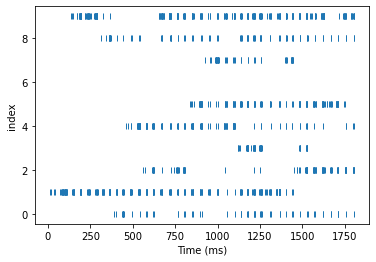

In [61]:
# Plotting output layer
plot(S2.t/ms, S2.i, '|')
xlabel('Time (ms)')
ylabel('index');

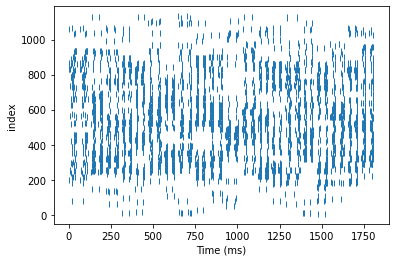

In [62]:
# Plotting the input spike trains
plot(S1.t/ms, S1.i, '|')
xlabel('Time (ms)')
ylabel('index');

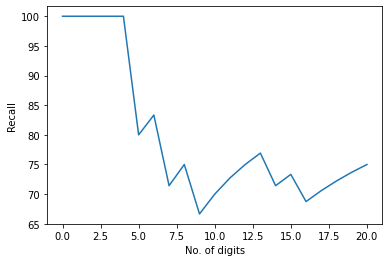

In [63]:
# Plotting the performance graph
tot_dig = 0
corr = 0
recall = [100]
for z in range(len(spike_digits)):
    if(predictions1[z]==spike_digits[z] or predictions2[z]==spike_digits[z] or predictions3[z]==spike_digits[z]):
        corr += 1
    tot_dig += 1
    recall.append((100*corr)/tot_dig)

plot(recall)
xlabel('No. of digits')
ylabel('Recall');  

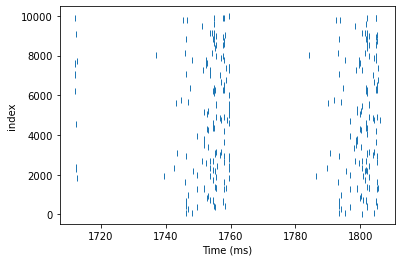

In [66]:
# Plotting the middle layer
plot(S3.t/ms, S3.i, '|')
xlabel('Time (ms)')
ylabel('index');